# ViT

paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)

#### pip install einops and pytorch-gpu 

In [13]:
import numpy as np
import math
import einops
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# pip install ipywidgets

### Read ViT paper and anwser the following TODO questions
### https://arxiv.org/pdf/2010.11929

## Download data 
#### turn on download=True if you use Colab

In [15]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=True),
    batch_size=128, shuffle=True)

In [16]:
data_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=False),
    batch_size=128, shuffle=True)

## helpers

In [17]:
@torch.no_grad()
def accuracy(model, label='test', silent=False):
    model.eval()
    dataset = data_test if label == 'test' else data
    count = 0
    correct = 0
    for x, y in dataset:
        x, y = x.to(device), y.to(device)
        res = model(x).argmax(-1)
        count += len(x)
        correct += (res == y).float().sum()
    acc = correct / count
    if not silent: print(f'accuracy on {label:5}: {acc}')
    return acc

In [18]:
def plot(*args, n_col=None, figsize=None, block_size=3, labels=None):
    '''Plot images in a grid
    usage: plot(img1, img2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1

    img: torch.Tensor of shape (H, W) or (C, H, W) or [(H, W), ...] or [(C, H, W), ...]
    '''
    imgs = []
    for img in args:
        if isinstance(img, torch.Tensor):
            if img.dim() == 4:
                imgs.extend([img[i] for i in range(img.shape[0])])
            else:
                imgs.append(img)
        if isinstance(img, list) or isinstance(img, tuple):
            assert all(isinstance(i, torch.Tensor) and i.dim() == 3 for i in img)
            imgs.extend(img)

    # flatten channels
    imgs = [img.squeeze(0) if img.dim() == 3 else img for img in imgs]
    imgs = [img.detach().cpu() for img in imgs]

    if n_col is None: n_col = len(imgs)
    n_row = math.ceil(len(imgs) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1:
        ax = np.array([[ax]])
    elif n_row == 1:
        ax = ax.reshape((1, -1))
    elif n_col == 1:
        ax = ax.reshape((-1, 1))
    # plot
    for i, img in enumerate(imgs):
        idx = (i // n_col, i % n_col)
        ax[idx].imshow(img)
        if labels and i < len(labels): ax[idx].set_title(labels[i])
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        if i >= len(imgs): ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
# test plot function
def test_plot(scale=3):
    imgs = next(iter(data))[0]
    plot(imgs[0], block_size=scale)
    plot(imgs[1], imgs[2], block_size=scale)
    plot(imgs[3], imgs[4], n_col=scale, block_size=scale)
    plot(imgs[5], imgs[6], imgs[7], n_col=2, block_size=scale)
    plot(imgs[:5], n_col=3, block_size=scale)

# test_plot()

## chunk images

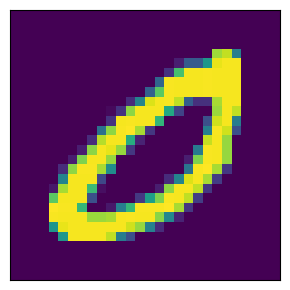

torch.Size([2, 1, 28, 28])


In [20]:
images = next(iter(data))[0][
         :2]  # `next(iter(data))` will return [128,1,28,28] wrapped by a list. It's to get top 2 image
plot(images[0])
print(images.size())

### Visualize the 4x4 image chunks 

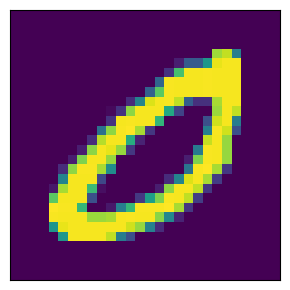

torch.Size([1, 28, 28])


In [21]:
b, c, h, w = images.shape
# cut into tiles
tile_size = 7
plot(images[0])
print(images[0].size())

### Use einops to speed the chunking'
### Explain TODO in comment

explain why tiles[0, 5, ...] are equal to images[B=0,C=0,H=7:14,W=7:14]

tiles 是把 images 中的 每个图像 横纵切割成 16 个 7 × 7 的小图像 (token) ，而 [0,5,0,:] 指的就是被 第 5 个被分割到的图像（下标从 0 开始），即为第 1 行第 1 列 的小图像。按照分割，这个小块的图像的像素值应该是原图像的 [7:14,7:14] 的像素值。故二者相等

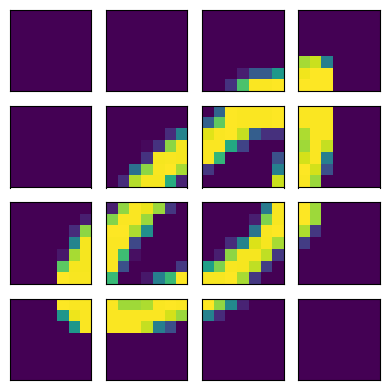

torch.Size([2, 16, 1, 7, 7])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1255, 0.4510],
        [0.0000, 0.0000, 0.0000, 0.0235, 0.1451, 0.8314, 0.9882],
        [0.0000, 0.0000, 0.0000, 0.1451, 0.9882, 0.9922, 0.9882],
        [0.0000, 0.0000, 0.3686, 0.8314, 0.9922, 1.0000, 0.8706],
        [0.0000, 0.1255, 0.8902, 0.9882, 0.9882, 0.6235, 0.0980]])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1255, 0.4510],
        [0.0000, 0.0000, 0.0000, 0.0235, 0.1451, 0.8314, 0.9882],
        [0.0000, 0.0000, 0.0000, 0.1451, 0.9882, 0.9922, 0.9882],
        [0.0000, 0.0000, 0.3686, 0.8314, 0.9922, 1.0000, 0.8706],
        [0.0000, 0.1255, 0.8902, 0.9882, 0.9882, 0.6235, 0.0980]])


In [22]:
# cut into tiles
tile_size = 7
tiles = einops.rearrange(images, 'b c (h t1) (w t2) -> b (h w) c t1 t2', t1=tile_size, t2=tile_size)
plot(tiles[0], n_col=4, block_size=1)
print(tiles.size())
# the tiles have size (Batch, 16=4x4, channel=1, H=7, W=7), that is the tokens are sequential
# explain why tiles[0, 5, ...] are equal to images[B=0,C=0,H=7:14,W=7:14]
# hint: the tiles[0, 5] is 5-th token of first image in batch, which is the row=1,col=1 token of size 7x7
# the image pixels are ?
print(tiles[0, 5, 0, :])
print(images[0, 0, 7:14, 7:14])
assert torch.allclose(tiles[0, 5, 0, :], images[0, 0, 7:14, 7:14])

## Encoder parameters
### TODO: explain what is the value of context_size and its meaning

In [23]:
N_HEADS = 2     # number of heads
N_BLOCKS = 2    # number of transformer blocks
VOCAB_SIZE = 10 # 十分类问题
EMBED_SIZE = 16 # 词嵌入维度
HIDDEN_SIZE = 32 # 隐藏层维度
IMG_SIZE = 28   # 图片大小
CHANNEL = 1     # 图片通道数
TILE_SIZE = 7   # 切片大小
assert IMG_SIZE % TILE_SIZE == 0    # 确保可以被 TILE_SIZE 整除
CONTEXT_SIZE = 1 + (IMG_SIZE // TILE_SIZE) ** 2 # 1 + (28/7)^2 = 17 （包括CLS token）
LEARNING_RATE = 3e-4 # 学习率
DROPOUT = 0.1   # dropout rate

In [24]:
CONTEXT_SIZE  # why add 1? (16 + 1)

17

### Sinuoid positional embedding
### TODO: refer to Transformer paper and explain the function of the position encoding

Transformer的第 pos 个位置的位置编码是一个这样的函数

$$
PE_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}}) \\
PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}})
$$

其中， $2i$, $2i+1$ 分别是位置编码的奇数/偶数维度，$d$ 是词向量的维度， 这个维
度等同于位置编码的维度， 这样位置编码就可以和词向量直接相加。

越往后的维度 $d$， 频率越小， 波长越长， 所以不同的位置 $t$ 对最终的结果影响
不大。 而越往左边走， 颜色交替的频率越频繁。

特征中的维度越大，周期越大，越容易捕捉到长距离的依赖关系

In [25]:
def get_sinusoidal_positional_encoding(context_size=CONTEXT_SIZE, embed_size=EMBED_SIZE):
    """
    正弦位置编码
    """
    position = torch.arange(context_size).unsqueeze(1) # [ [0], [1], [2], ... ]
    div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size)) # [1, 10000^-1, 10000^-2, ...]
    positional_encoding = torch.zeros(context_size, embed_size)
    positional_encoding[:, 0::2] = torch.sin(position * div_term)   # 正弦作为偶数位置
    positional_encoding[:, 1::2] = torch.cos(position * div_term)   # 余弦作为奇数位置
    return positional_encoding.to(device)

### TODO: Explain each step in MultiheadAttention forward function and associate with the QKV equation
### TODO: Explain why self.qkv is one linear function instead of three
### TODO: Explain why q,k,v transpose(1,2) and y transpose back

*多头注意力其实就是把嵌入空间分成多个子空间，然后在每个子空间上进行注意力计算*

In [26]:
class MultiheadAttention(nn.Module):
    def __init__(self, n_heads, embed_size, dropout, n_block=0):
        super().__init__()
        assert embed_size % n_heads == 0, f'{embed_size=} should be divisible by {n_heads=}'
        self.n_heads = n_heads
        self.embed_size = embed_size
        self.dropout_rate = dropout
        self.n_block = n_block  # The No. of this MHA
        self.qkv = nn.Linear(embed_size, embed_size * 3, bias=False)  # generate Q, K, V all at once
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(embed_size)

    def forward(self, x):
        B, C, E = x.shape # B: batch size, C: context size, E: embed size
        # pre-layernorm
        x = self.ln(x)
        q, k, v = self.qkv(x).chunk(3, dim=-1) # split Q, K, V, each has shape [B, C, E]
        # split heads
        # 一个头的维度是 E/H （把 embed_size 分成 n_heads 份）
        # [B, C, E] -> [B, C, H, E/H] -> [B, H, C, E/H]
        q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        # compute QKV
        correlation = q @ k.transpose(-2, -1) # [B, H, C, E/H] @ [B, H, E/H, C] = [B, H, C, C]
        correlation = correlation / math.sqrt(k.shape[-1]) # scale
        correlation = F.softmax(correlation, dim=-1)
        correlation = F.dropout(correlation, p=self.dropout_rate, training=self.training)
        y = correlation @ v # [B, H, C, C] @ [B, H, C, E/H] = [B, H, C, E/H]
        # combine heads
        # [B, H, C, E/H] -> [B, C, H, E/H] -> [B, C, E]
        y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size) # contiguous() is needed for view, 使得 y 的内存连续
        y = self.dropout(y)
        return y

    def forward_visualize(self, x):
        B, C, E = x.shape
        # pre-layernorm
        x = self.ln(x)
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        # split heads
        q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        # by hand
        correlation = q @ k.transpose(-2, -1)
        correlation = correlation / math.sqrt(k.shape[-1])
        correlation = F.softmax(correlation, dim=-1)
        correlation = F.dropout(correlation, p=self.dropout_rate, training=self.training)
        y = correlation @ v
        # combine heads
        y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size)
        y = self.dropout(y)
        return y, correlation


class Block(nn.Module):
    def __init__(self, n_heads, embed_size, hidden_size, dropout, n_block):
        super().__init__()
        self.block = n_block
        self.attention = MultiheadAttention(n_heads, embed_size, dropout=dropout, n_block=n_block)
        self.ff = nn.Sequential(
            nn.LayerNorm(embed_size),  # pre-layernorm
            nn.Linear(embed_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_size),
            nn.Dropout(dropout)
        ) # feed forward

    def forward(self, x):
        x = x + self.attention(x) # residual connection (skip connection)
        x = x + self.ff(x)  # residual connection (skip connection)
        return x

    def forward_visualize(self, x):
        x1, cor = self.attention.forward_visualize(x)
        x = x + x1
        x = x + self.ff(x)
        return x, cor


### TODO: explain what is the size and functionality of tile_embedding layer 

`cls_token` 是用于分类的 token 放在图像的最前面 “分类头”，经过多层处理后，`cls_token` 被认为聚合了整个图像的信息，其输出就是整个图像的分类结果

疑问：

- 为什么要把 `cls_token` 放在最前面，而不是放在最后面？
- 为什么只取经过

In [ ]:
class Net(nn.Module):
    def __init__(self, n_heads=N_HEADS, n_blocks=N_BLOCKS, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE,
                 vocab_size=VOCAB_SIZE, context_size=CONTEXT_SIZE, dropout=DROPOUT, tile_size=TILE_SIZE):
        super().__init__()
        self.context_size = context_size
        self.tile_size = tile_size
        # net
        self.positional_embedding = get_sinusoidal_positional_encoding()
        self.tile_embedding = nn.Linear(TILE_SIZE * TILE_SIZE * CHANNEL, embed_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size)) # learnable cls token (at the beginning)
        self.blocks = nn.Sequential(*[Block(n_heads, embed_size, hidden_size, dropout, i) for i in range(n_blocks)])
        self.head = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        # (batch_size, channel, height, width)
        # split into tiles/patches/chunks
        # [B, C, H, W] -> [B, (H/t1) * (W/t2), (C*t1*t2)]
        x = einops.rearrange(x, 'b c (h t1) (w t2) -> b (h w) (c t1 t2)', t1=self.tile_size, t2=self.tile_size)
        
        # embed
        # [B, (H/t1) * (W/t2), (C*t1*t2)] -> [B, (H/t1) * (W/t2), E]
        x = self.tile_embedding(x)
        
        # add cls token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1) # [B, 1 + (H/t1) * (W/t2) , E]
        
        # positional encoding
        x = x + self.positional_embedding
        # attention and ff
        # input, output: [B, 1 + (H/t1) * (W/t2) , E] 
        x = self.blocks(x)
        # head
        # [B, 1 + (H/t1) * (W/t2) , E] -> [B, 1 + (H/t1) * (W/t2) , V]
        x = self.head(x)
        # only look at first token:
        # [B, 1 + (H/t1) * (W/t2) , V] -> [B, V]
        x = x[:, 0, :]
        return x

    def forward_visualize(self, x):
        # (batch_size, channel, height, width)
        # split into tiles/patches/chunks
        x = einops.rearrange(x, 'b c (h t1) (w t2) -> b (h w) (c t1 t2)', t1=self.tile_size, t2=self.tile_size)
        # embed
        x = self.tile_embedding(x)
        # add cls token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        # positional encoding
        x = x + self.positional_embedding
        all_corrs = []
        for block in self.blocks:
            x, corr = block.forward_visualize(x)
            all_corrs.append(corr.detach())

        x = self.head(x)
        # only look at first token:
        x = x[:, 0, :]
        return x, all_corrs


## Training stage

### TODO: Draw outline of this ViT, including the exact number of blocks

In [28]:
model = Net(n_heads=2, n_blocks=2).to(device)

In [29]:
# resume training if you want
# model.load_state_dict(torch.load('weights/vit_mnist_epoch20.pt'))

In [41]:
next(iter(data))[1][0]

tensor(3)

### If you don't have a GPU, borrow one checkpoint file from your classmate, and skip the training steps
### If you have a 4060 or better GPU, try running for 50 steps or more, and check the accuracy

#### 交叉熵

会自动将模型的输出和真实标签进行比较。具体来说，它会对模型的输出进行 softmax 操作，将其转换为概率分布，然后计算与真实标签之间的交叉熵。

In [ ]:
# Training steps

epochs = 31  # feel free to change to 100
lr = LEARNING_RATE
model.train()
opt = torch.optim.Adam(model.parameters(), lr=lr)
log_every = 2
save_every = 10

for epoch in range(epochs):
    for X, Y in data:
        X, Y = X.to(device), Y.to(device)
        out = model(X)
        loss = F.cross_entropy(out, Y)
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % log_every == 0:
        # print loss
        print(f'{epoch:5} {loss.item()}')

    if epoch > 5 and epoch % save_every == 0:
        # save model
        torch.save(model.state_dict(), 'weights/vit_mnist_epoch%02d.pt' % (epoch,))


    0 1.3029038906097412
    2 0.4274389445781708
    4 0.4746716320514679
    6 0.5612088441848755
    8 0.4962600767612457
   10 0.3848865032196045
   12 0.40621110796928406
   14 0.5319077372550964
   16 0.3911084830760956
   18 0.3693489134311676
   20 0.396232008934021
   22 0.2031618356704712
   24 0.2802884876728058
   26 0.3153618276119232
   28 0.24806956946849823
   30 0.25776517391204834



### Wait for training finished, or you can interrupt, and load a saved model 

In [42]:
model.load_state_dict(torch.load('weights/vit_mnist_epoch30.pt'))

/tmp/ipykernel_141011/1528925991.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/vit_mnist_epoch30.pt'))


<All keys matched successfully>

In [43]:
# test set accuracy
_ = accuracy(model)
# train set accuracy
_ = accuracy(model, label='train')

accuracy on test : 0.9442999958992004
accuracy on train: 0.9474000334739685


## visualizations

### visualize failures

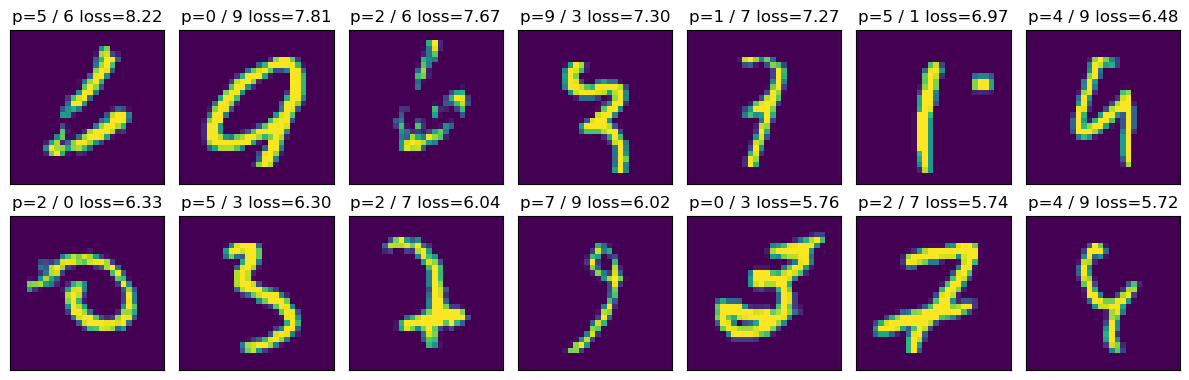

In [23]:
@torch.no_grad()
def failing(model, ds=data_test):
    model.eval()
    misslabeled_imgs = []
    losses = []
    wrong_labels = []
    real_labels = []
    for x, y in ds:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        out = logits.argmax(-1)
        losses.append(-logits.softmax(1)[torch.arange(logits.shape[0]), y].log()[out != y])
        misslabeled_imgs.append(x[out != y])
        wrong_labels.append(out[out != y])
        real_labels.append(y[out != y])
    return torch.cat(misslabeled_imgs), torch.cat(wrong_labels), torch.cat(real_labels), torch.cat(losses)


def sorted_failing(model, ds=data_test, descending=True):
    imgs, wrong_labels, real_labels, losses = failing(model, ds)
    order = losses.argsort(descending=descending)
    return imgs[order], wrong_labels[order], real_labels[order], losses[order]


def plot_failing(imgs, wrong_labels, real_labels, n_col=7, figsize=(12, 4)):
    fig, ax = plt.subplots(2, n_col, figsize=figsize)

    for i in range(imgs.shape[0]):
        idx = (i // n_col, i % n_col)
        img = imgs[i].cpu().permute(1, 2, 0)
        ax[idx].imshow(img)
        ax[idx].set_title(f'p={wrong_labels[i].item()} / {real_labels[i].item()} loss={losses[i].item():.2f}')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    plt.tight_layout()
    plt.show()


misslabeled_imgs, wrong_labels, real_labels, losses = sorted_failing(model)
plot_failing(misslabeled_imgs[:14], wrong_labels[:14], real_labels[:14])

### Plot confusion matrix
### TODO: We want to know which classes are misclassified the most.
### TODO: Provide top-5 cases, that True class A is misclassified as B.  Print A->B

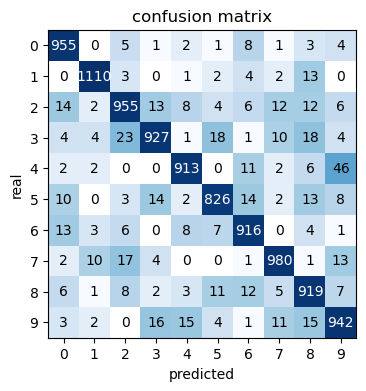

In [77]:
@torch.no_grad()
def label_all(model, ds=data_test):
    model.eval()
    predicted_labels = []
    real_labels = []
    for x, y in ds:
        x, y = x.to(device), y.to(device)
        out = model(x).argmax(-1)
        predicted_labels.append(out)
        real_labels.append(y)
    return torch.cat(predicted_labels), torch.cat(real_labels)


def to_confusion_matrix(predicted_labels, real_labels):
    confusion_matrix = torch.zeros((10, 10), dtype=torch.int32)
    for p, r in zip(predicted_labels, real_labels):
        confusion_matrix[r, p] += 1
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, figsize=(5, 4)):
    num_classes = confusion_matrix.shape[0]
    plt.figure(figsize=figsize)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues', norm=colors.LogNorm())
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, int(confusion_matrix[i, j]),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2. else "black")
    plt.title('confusion matrix')
    plt.xlabel('predicted')
    plt.ylabel('real')
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))
    plt.show()


predicted_labels, real_labels = label_all(model)
confusion_matrix = to_confusion_matrix(predicted_labels, real_labels)
plot_confusion_matrix(confusion_matrix)

In [ ]:
cases_mis = []
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        if i != j:  # get each case of misclassification
            cases_mis.append((i, j, confusion_matrix[i, j].item()))
cases_mis.sort(reverse=True, key=lambda x: x[2]) # sort
for real_class, predicted_class, n in cases_mis[:5]:
    print(f'{real_class} -> {predicted_class}: {n} times')  # Print

4 -> 9: 46 times
3 -> 2: 23 times
3 -> 5: 18 times
3 -> 8: 18 times
7 -> 2: 17 times


### Visualize attention
### TODO: what do you find the activation map?  
### Display one digit as example and explain which token i is mostly associated with token j

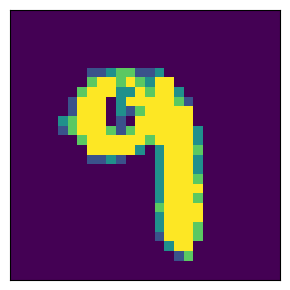

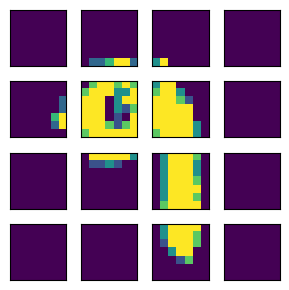

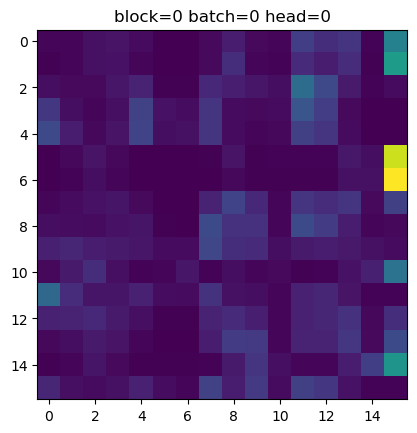

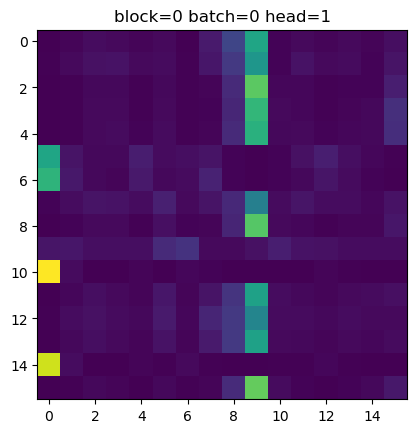

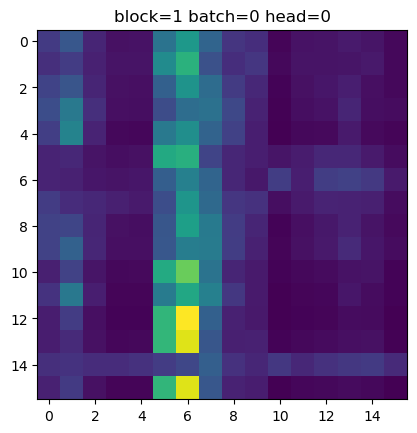

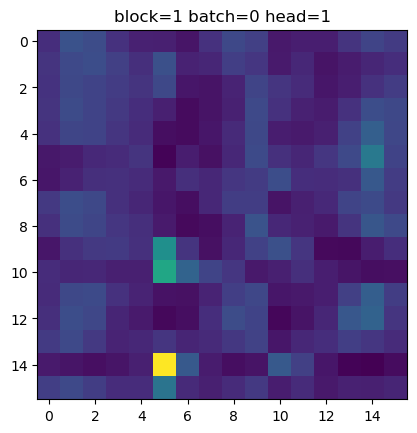

In [81]:
from matplotlib.ticker import MaxNLocator


@torch.no_grad()
def visualize_attention(model, img):
    model.eval()
    plot(img)
    tiles = einops.rearrange(img, 'c (h t1) (w t2) -> (h w) c t1 t2', t1=TILE_SIZE, t2=TILE_SIZE)
    plot(tiles, n_col=4, block_size=0.75)
    img = img.to(device).unsqueeze(0)
    out, activations = model.forward_visualize(img)
    out = out.argmax(-1).item()

    plt.gca().axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    for block, acts in enumerate(activations):
        for batch, acts in enumerate(torch.unbind(acts, dim=0)):
            for head, acts in enumerate(torch.unbind(acts, dim=0)):
                # 17x17 attention magnitude
                acts = acts[1:,1:].cpu()
                plt.title(f'block={block} batch={batch} head={head}')
                plt.imshow(acts)
                plt.show()


visualize_attention(model, next(iter(data))[0][0])

### Visualize positional embeddings
#### note that emb is (1 + patch_number) * embed_size
#### we discard the first [cls], then visualize patch_number*embed_size

torch.Size([17, 16])


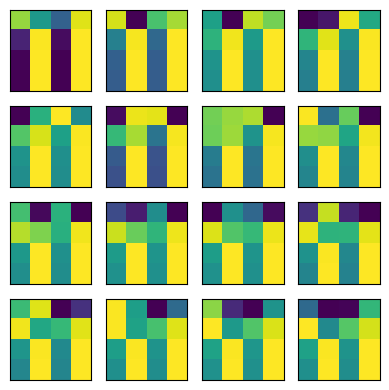

In [26]:
@torch.no_grad()
def visualize_positional_embeddings(emb):
    print(emb.size())
    # strip cls token
    emb = emb[1:]
    emb = einops.rearrange(emb, 'n (k1 k2) -> n 1 k1 k2', k1=4)
    plot(emb, n_col=4, block_size=1)


visualize_positional_embeddings(model.positional_embedding)